In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from glob import glob
import copy
import joblib
from tqdm import tqdm
tqdm.pandas()
import gc
from collections import defaultdict
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim import lr_scheduler
import cv2
import matplotlib
from torch.nn import Identity
matplotlib.style.use('ggplot')
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
Image.MAX_IMAGE_PIXELS = None
pd.set_option('display.float_format', '{:.2f}'.format)
import segmentation_models_pytorch as smp
from torchvision.models.resnet import Bottleneck, ResNet
from torchvision import transforms
import pickle
from natsort import natsorted
from sklearn.metrics import f1_score

In [4]:
class model_config:
    current_fold = 1  #number of CV fold to train
    key = "BT"  #key of resnet model to train if pretrained_resnet = True
    pretrained_resnet = False  #whether to train using a pretrained resnet model
    seed = 42  #random seed
    train_batch_size = 4
    valid_batch_size = 8
    epochs = 300
    learning_rate = 0.002  # 0.001 for bs=16
    scheduler = "CosineAnnealingLR"  #explore different lr schedulers, with cosineannealingLR, at T_max, the learning rate will be about half of initial lr above.
    num_training_samples = 160
    T_max = max(10,int(
        num_training_samples / train_batch_size * epochs))  #number of iterations for a full cycle, need to change for different # of iterations (iteration = batch size). low BS and num_train sample -> low T_max.
    weight_decay = 1e-6  #explore different weight decay (for Adam optimizer)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    iters_to_accumulate = max(1, 32 // train_batch_size)  #for scaling accumulated gradients, should never be <1
    eta_min = 1e-5
    model_save_directory = os.path.join(os.getcwd(), "model",
                                        "DeepLabV3+_baseline")  #assuming os.getcwd is the current training script directory

In [3]:
#sets the seed of the entire notebook so results are the same every time we run for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)  #numpy specific random
    random.seed(seed)  #python specific random (also for albumentation augmentations)
    torch.manual_seed(seed)  #torch specific random
    torch.cuda.manual_seed(seed)  #cuda specific random
    #when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  #when deterministic = true, benchmark = False, otherwise might not be deterministic

    os.environ['PYTHONHASHSEED'] = str(seed)  #set a fixed value for the hash seed, for hashes like dictionary
set_seed(model_config.seed)  # set seed first

In [4]:
#only simple transforms, since training data is already transformed.
train_transforms = A.Compose([
    A.GaussNoise(p=0.2),
    A.ToGray(p=0.2),
    ToTensorV2() #V2 converts tensor to CHW automatically
])
val_transforms = A.Compose([ToTensorV2()])

In [5]:
#for current fold, get the image and mask paths accordingly:
data_src = r"C:\Users\Kevin\Desktop\deeplab_trainingset"
fold_dir = r"v11_fold{}".format(model_config.current_fold)
image_path = os.path.join(data_src, fold_dir)
train_dir = os.path.join(image_path,"training")
val_dir = os.path.join(image_path,"validation")

train_image_dir = os.path.join(train_dir, "im")
train_label_dir = os.path.join(train_dir,'label')
training_images = natsorted([os.path.join(train_image_dir,x) for x in os.listdir(train_image_dir) if x.endswith(".png")])
training_labels = natsorted([os.path.join(train_label_dir,x) for x in os.listdir(train_label_dir) if x.endswith(".png")])

val_image_dir = os.path.join(val_dir, "im")
val_label_dir = os.path.join(val_dir,'label')
val_images = natsorted([os.path.join(val_image_dir,x) for x in os.listdir(val_image_dir) if x.endswith(".png")])
val_labels = natsorted([os.path.join(val_label_dir,x) for x in os.listdir(val_label_dir) if x.endswith(".png")])

In [6]:
class TrainDataSet(Dataset):
    #initialize df, label, imagepath, transforms:
    def __init__(self, image_paths: list, mask_paths: list, transforms=None, label=True):
        self.label = label
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
    def __len__(self):
        return len(self.image_paths)

    #define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        if self.label:
            mask_path = self.mask_paths[idx]
            mask = cv2.imread(mask_path, 0)
            mask = np.array(mask)
        if self.transforms is not None:  #albumentations
            transformed = self.transforms(image=image,mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.unsqueeze(0) #dtypes: image = torch.uin8, mask = torch.uint8
        return image, mask  #return tensors of equal dtype and size
        #image is size 3x1024x1024 and mask is size 1x1024x1024 (need dummy dimension to match dimension)

In [7]:
#define dataloading function to use above dataset to return train and val dataloaders:
def load_dataset():
    train_dataset = TrainDataSet(image_paths = training_images, mask_paths = training_labels, transforms=train_transforms)
    val_dataset = TrainDataSet(image_paths = val_images, mask_paths = val_labels, transforms=val_transforms)
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=model_config.train_batch_size,
                                  #pin_memory= true allows faster data transport from cpu to gpu
                                  num_workers=0, pin_memory=True, shuffle=False)
    val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=model_config.valid_batch_size,
                                num_workers=0, pin_memory=True, shuffle=False)
    return train_dataloader, val_dataloader #return train and val dataloaders

In [8]:
#test to see if dataloaders return desired batch size and visualize images to see if images are indeed transformed:
train_dataloader, val_dataloader = load_dataset()
images, labels = next(iter(train_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))
images, labels = next(iter(val_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))

Images have a tensor size of torch.Size([4, 3, 1024, 1024]), and Labels have a tensor size of torch.Size([4, 1, 1024, 1024])
Images have a tensor size of torch.Size([8, 3, 1024, 1024]), and Labels have a tensor size of torch.Size([8, 1, 1024, 1024])


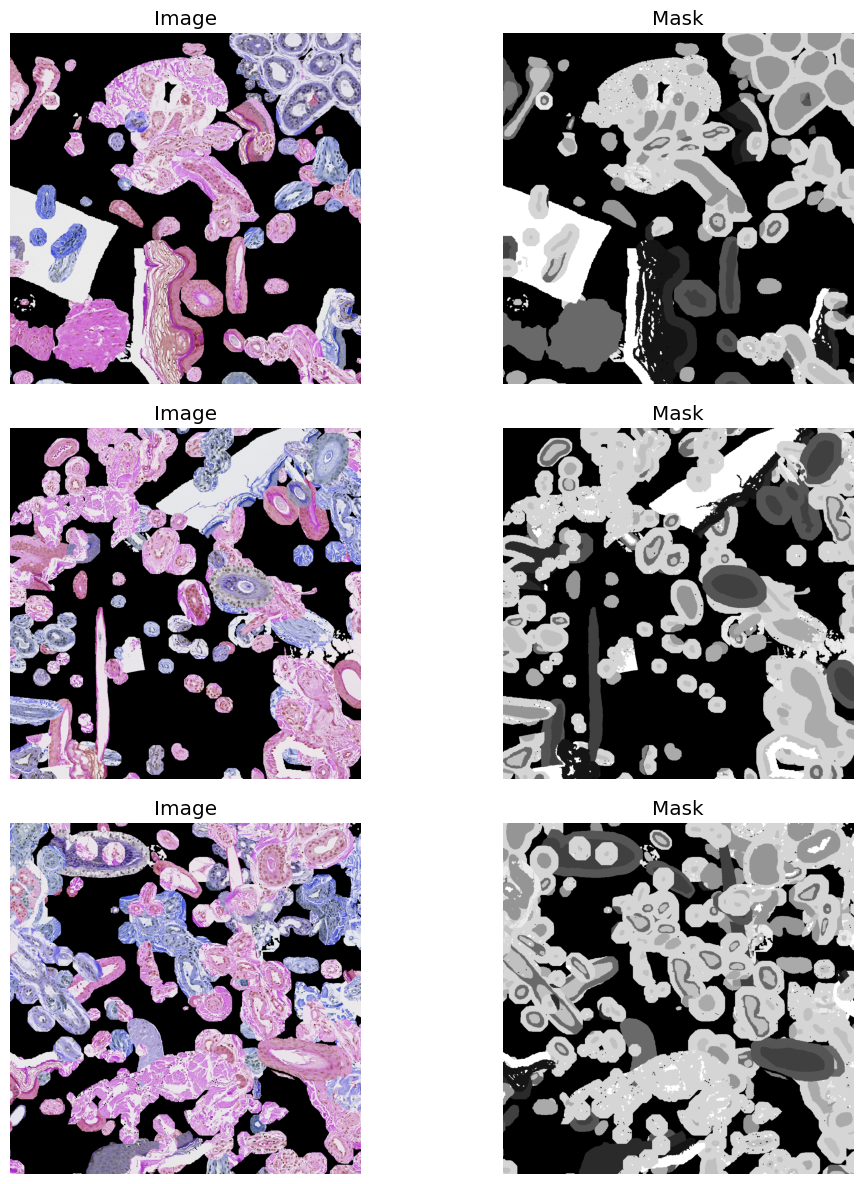

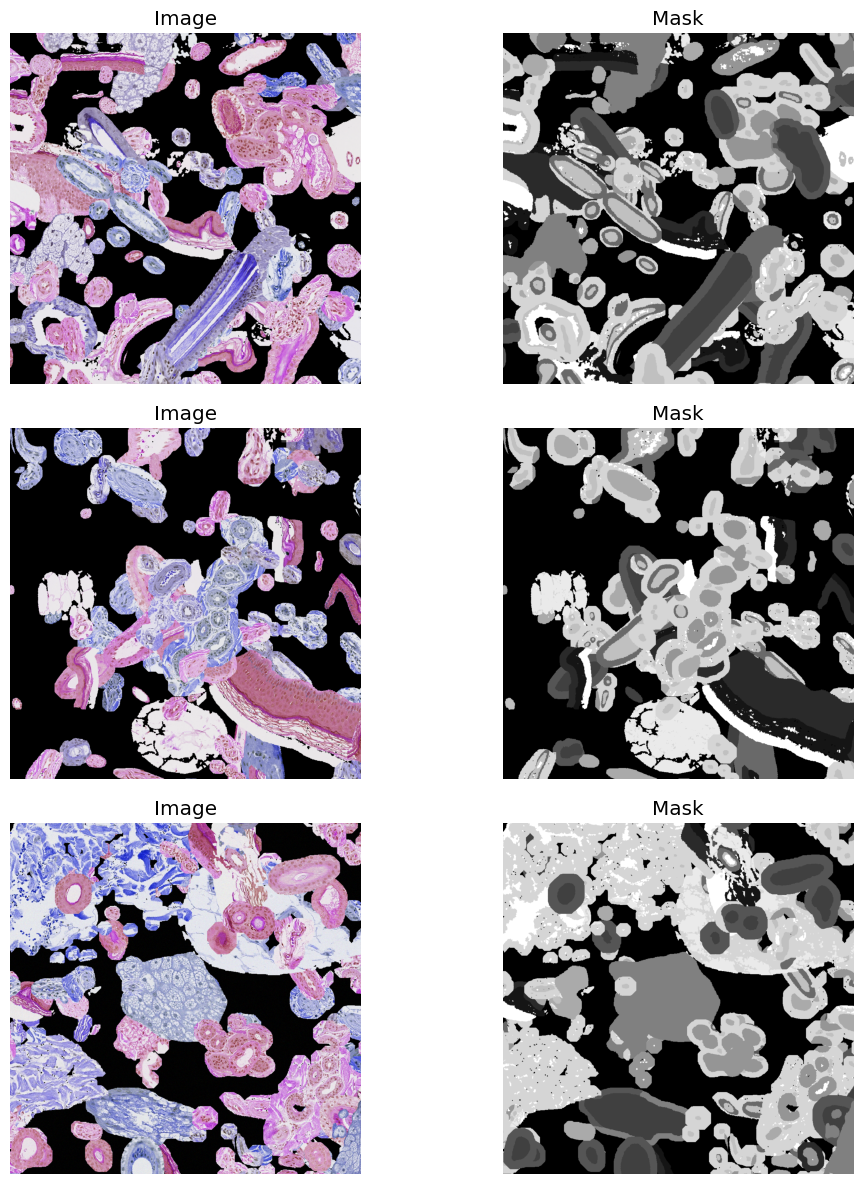

In [9]:
def visualize_images(dataset: torch.utils.data.Dataset, num_images: int):
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 12))
    fig.tight_layout()
    for i, ax_row in enumerate(axes):
        index = indices[i]
        image, mask = dataset[index]
        if dataset.transforms is not None:
            ax_row[0].imshow(image.permute(1,2,0))
        else:
            ax_row[0].imshow(image)

        ax_row[0].set_title("Image")
        ax_row[0].axis("off")

        if dataset.transforms is not None:
            ax_row[1].imshow(mask.squeeze(0), cmap="gray")
        else:
            ax_row[1].imshow(mask, cmap="gray")
        ax_row[1].set_title("Mask")
        ax_row[1].axis("off")
    plt.show()

visualize = True #always check if transforms properly applied before training
if visualize:
    original_dataset = TrainDataSet(image_paths = training_images, mask_paths = training_labels, transforms=None)
    visualize_images(original_dataset, num_images=3)
    train_dataset = TrainDataSet(image_paths = training_images, mask_paths = training_labels, transforms=train_transforms)
    visualize_images(train_dataset, num_images=3)

In [10]:
#below is code to fetch H&E domain specific pretrained resnet50 weights if that pretrained_resnet = True:
#code and model credits to: https://github.com/lunit-io/benchmark-ssl-pathology
class ResNetTrunk(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        del self.fc  # remove FC layer
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
def get_pretrained_url(key):
    URL_PREFIX = "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights"
    model_zoo_registry = {
        "BT": "bt_rn50_ep200.torch",
        "MoCoV2": "mocov2_rn50_ep200.torch",
        "SwAV": "swav_rn50_ep200.torch",
    }
    pretrained_url = f"{URL_PREFIX}/{model_zoo_registry.get(key)}"
    return pretrained_url

def resnet50(pretrained, progress, key, **kwargs):
    model = ResNetTrunk(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_url = get_pretrained_url(key)
        verbose = model.load_state_dict(
            torch.hub.load_state_dict_from_url(pretrained_url, progress=progress)
        )
        print(verbose)
    return model

if model_config.pretrained_resnet:
    pretrained_url = get_pretrained_url(model_config.key)

In [11]:
def build_model():
    if model_config.pretrained_resnet: #only pretrained resnet50 available
        model = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights=model_config.key, encoder_depth = 5,
                                 decoder_channels = 512, activation=None, in_channels=3, classes=13)
    else: #try different encoders
        model = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", encoder_depth = 5,
                                 decoder_channels = 512, activation=None,
                                 in_channels=3, classes=13)
    model.to(model_config.device)  #move model to gpu
    return model

In [12]:
# define loss function and validation metric f1-score:
def loss_func(y_pred: torch.Tensor,y_true: torch.Tensor):
    return nn.CrossEntropyLoss()(y_pred,y_true) #has softmax built in to it.

def f1_score(y_pred: torch.Tensor, y_true: torch.Tensor, threshold): #y_pred in probabilities
    y_pred = y_pred.cpu().numpy().flatten() # 1d numpy array
    y_true = y_true.cpu().numpy().flatten() # 1d numpy array
    return f1_score(y_pred,y_true, average = "weighted") #macro = unweighted mean, so more frequent label is heavily influenced, whereas weighted = weighted mean, accounts for label imbalance.

In [13]:
#code to train one epoch:
def epoch_train(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()  #set mode to train
    dataset_size = 0  #initialize
    running_loss = 0.0  #initialize
    scaler = GradScaler()  #enable GradScaler for gradient scaling, necessary for prevention of underflow of using fp16 using autocast below
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train', colour='red')
    for idx, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)  #move tensor to gpu
        masks = masks.to(device, dtype=torch.int64)  #move tensor to gpu
        batch_size = model_config.train_batch_size  #return batch size N.
        with autocast(enabled=True, dtype=torch.float16):  #enable autocast for fp16 training, faster forward pass
            y_pred = model(images)  #forward pass, y_pred: N x 13 x 1024 x 1024
            print("y_pred is: {} and size is {} and dtype is {}".format(y_pred,y_pred.size(),y_pred.dtype))
            masks = masks.squeeze(1)
            # y_pred_final = torch.argmax(y_pred,dim=1).to(torch.int64)
            print("masks is: {} and size is {} and dtype is {}".format(masks,masks.size(),masks.dtype))
            # print("y_pred_final is: {} and size is {} and dtype is {}".format(y_pred_final,y_pred_final.size(),y_pred_final.dtype))
            loss = loss_func(y_pred, masks)  #compute losses from y_pred
            print(loss)
            loss = loss / model_config.iters_to_accumulate  #need to normalize since accumulating gradients
        scaler.scale(loss).backward()  #backward pass, make sure it is not within autocast
        if (idx + 1) % model_config.iters_to_accumulate == 0 :  #scale updates should only happen at each # of iters to accumulate
            scaler.step(optimizer) #take optimizer step
            scaler.update()  #update scale for next iteration
            optimizer.zero_grad()  #zero the accumulated scaled gradients
            scheduler.step()  #change lr,make sure to call this after scaler.step
        running_loss += (loss.item() * batch_size)  #update current running loss for all images in batch
        dataset_size += batch_size  #update current datasize
        epoch_loss = running_loss / dataset_size  #get current epoch average loss
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}') #print current epoch loss and lr
    torch.cuda.empty_cache()  #clear gpu memory after every epoch
    gc.collect() #collect garbage
    return epoch_loss  #return loss for this epoch

In [14]:
#code to visualize images during validation to check training is progressing:
def visualize_images_validation(image,mask,y_pred,epoch):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
    fig.tight_layout()
    image = image.cpu().numpy()
    axes[0].imshow(image.transpose(1,2,0).astype(np.uint8))
    axes[0].set_title("H&E Validation Image for epoch {}".format(epoch))
    axes[0].axis("off")
    mask = mask.cpu().numpy()
    axes[1].imshow(mask.squeeze(0),cmap="gray")
    axes[1].set_title("Ground Truth Validation Mask for epoch {}")
    axes[1].axis("off")
    y_pred = y_pred.cpu().numpy()
    axes[2].imshow(y_pred.squeeze(0),cmap="gray")
    axes[2].set_title("Model Predicted Validation Mask for epoch {}".format(epoch))
    axes[2].axis("off")
    plt.show()

In [15]:
@torch.no_grad()  #disable gradient calc for validation
def epoch_valid(model, dataloader, device, epoch):
    model.eval()  #set mode to eval
    dataset_size = 0  #initialize
    running_loss = 0.0  #initialize
    valid_ap_history = [] #initialize
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Validation', colour='red')
    for idx, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float) #move tensor to gpu
        masks = masks.to(device, dtype=torch.int64) #move tensor to gpu
        y_pred = model(images)  #forward pass
        if (idx == 0 or idx == 2) and epoch % 4 == 0: #visualize random images at every 4 epochs to make sure training is progressing
            image = images[0] #first H&E image of batch
            mask = masks[0] #first ground truth mask of batch
            y_pred_prob = F.softmax()(y_pred) #get prob by applying sigmoid to logit y_pred
            y_pred_ind = y_pred_prob[0] #get model prediction of prob, same image as ground truth above
            visualize_images_validation(image,mask,y_pred_ind,epoch) #visualize H&E image, ground truth segmentation, and predicted segmentation
        loss = loss_func(y_pred, masks) #calculate loss
        running_loss += (loss.item() * model_config.valid_batch_size)  #update current running loss
        dataset_size += model_config.valid_batch_size  #update current datasize
        epoch_loss = running_loss / dataset_size  #divide epoch loss by current datasize
        masks = masks.squeeze(0)
        y_pred_prob = F.softmax()(y_pred) #get prob by applying sigmoid to logit y_pred
        print(masks.size)
        print(y_pred_prob.size)
        # valid_f1 = f1_score(y_pred_prob,masks, threshold = 0.5) #find f1 score
        # valid_ap_history.append(valid_ap)
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.3f}',
                         lr=f'{current_lr:0.4f}')
    # valid_ap_history = np.mean(valid_ap_history, axis=0) #store mean AP
    torch.cuda.empty_cache()  #clear gpu memory after every epoch
    gc.collect() #collect garbage

    return epoch_loss #, valid_ap_history  #return loss and AP for this epoch

In [16]:
#function that utilizes above train and validation function to iterate them over training epochs, master train code.
def run_training(model, optimizer, scheduler, device, num_epochs):
    start = time.time()  #measure time
    best_model_wts = copy.deepcopy(model.state_dict())
    best_ap = 0  #initial best AP
    best_epoch = -1  #initial best epoch
    history = defaultdict(list)  #history defaultdict to store relevant variables

    for epoch in range(1, num_epochs + 1): #iter over num total epochs
        gc.collect()
        print("Current Epoch {} / Total Epoch {}".format(epoch, num_epochs))
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = epoch_train(model, optimizer, scheduler, dataloader=train_dataloader, device=model_config.device, epoch=epoch) #train one epoch
        valid_loss = epoch_valid(model, dataloader=val_dataloader, device=model_config.device, epoch=epoch) #valid one epoch
        # valid_ap = valid_ap_history
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(valid_loss)
        # history['Valid AP'].append(valid_ap)
        # print(f'Valid AP: {valid_ap:0.4f}')
        #if AP improves, save the best model

        # if valid_ap >= best_ap:
        #     print(f"Valid Score Improved ({best_ap:0.4f} ---> {valid_ap:0.4f})")
        #     best_ap = valid_ap
        #     best_epoch = epoch
        #     best_model_wts = copy.deepcopy(model.state_dict())
        #     PATH = os.path.join(model_config.model_save_directory, f"best_epoch-{model_config.current_fold:02d}.pt")
        #     if not os.path.exists(model_config.model_save_directory):
        #         os.makedirs(model_config.model_save_directory)
        #     torch.save(model.state_dict(), PATH)
        #     print("Model Saved!")
        # print(f'Best AP so far: {best_ap:0.4f}')
        # print(f'Best AP at epoch #: {best_epoch:d}')

        #also save the most recent model
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = os.path.join(model_config.model_save_directory, f"latest_epoch-{model_config.current_fold:02d}.pt")
        if not os.path.exists(model_config.model_save_directory):
            os.makedirs(model_config.model_save_directory)
        torch.save(model.state_dict(), PATH)

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60))
    # print("Best AP@ 0.6IOU: {:.4f}".format(best_ap))

    #load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
#finally run training:
train_dataloader, valid_dataloader = load_dataset() #load datasets
model = build_model() #build model
print(model)
optimizer = optim.Adam(model.parameters(),
                       lr=model_config.learning_rate,
                       weight_decay=model_config.weight_decay)  #initialize optimizer
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                               T_max=model_config.T_max,
                                               eta_min=model_config.eta_min) #initialize LR scheduler
print("Training for Fold {}".format(model_config.current_fold))
model, history = run_training(model, optimizer, scheduler,
                              device=model_config.device,
                              num_epochs=model_config.epochs) #run training for each fold
pkl_save_path = os.path.join(model_config.model_save_directory, 'history.pickle')
#save history as pkl:
with open(pkl_save_path, 'wb') as file:
    pickle.dump(history, file)

__main__.model_config